In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, random

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        # Initialize the object
        self.data = data
        self.grad = 0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Method for adding two Value objects or a value object with a non-Value object
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # Method for backward pass on a plus operation, while accumulating gradients
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        # Method for multiplying two Value objects or a value object with a non-Value object
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        # Method for backward pass on a muliplication operation, while accumulating gradients
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f"^{other}")
        def _backward():
            self.grad += (other * (self.data)**(other - 1))*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.e**self.data, (self, ), f"exp")
        def _backward():
            self.grad += (out.data*out.grad)
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value(((math.e**(2*self.data) - 1)/(math.e**(2*self.data) + 1)), (self, ), _op='tanh')
        def _backward():
            self.grad += (1-out.data**2)*out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(self.data if self.data > 0 else 0.0, (self,), 'ReLU')
        def _backward():
            self.grad += (1.0 if self.data > 0 else 0.0) * out.grad
        out._backward = _backward
        return out

    
    def backward(self):
        # topological order of all children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward() 

    def __neg__(self):
        return self*(-1.0)
    
    def __radd__(self, other):
        return self+other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self*(other**-1)
    
    def __rtruediv__(self, other):
        return other*(self**-1)

In [2]:
from graphviz import Digraph

def trace(root):
    # build a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

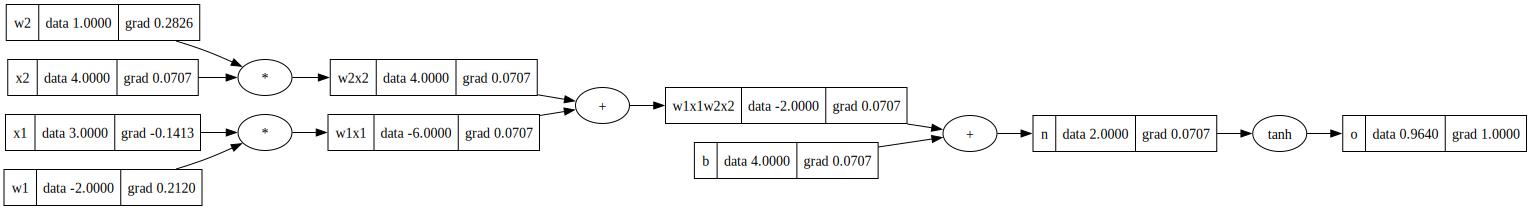

In [3]:
x1 = Value(3.0, label='x1')
x2 = Value(4.0, label='x2')
w1 = Value(-2.0, label='w1')
w2 = Value(1.0, label='w2')

w1x1 = w1*x1
w1x1.label='w1x1'

w2x2 = w2*x2
w2x2.label='w2x2'

w1x1w2x2 = w1x1 + w2x2
w1x1w2x2.label='w1x1w2x2'

b = Value(4.0)
b.label='b'

n = w1x1w2x2 + b
n.label='n'

o = n.tanh()
o.label='o'

o.backward()

draw_dot(o)

In [4]:
def lol():
    h = 0.0001
    x1 = Value(3.0, label='x1')
    x2 = Value(4.0, label='x2')
    w1 = Value(-2.0, label='w1')
    w2 = Value(1.0, label='w2')

    w1x1 = w1*x1
    w1x1.label='w1x1'

    w2x2 = w2*x2
    w2x2.label='w2x2'

    w1x1w2x2 = w1x1 + w2x2
    w1x1w2x2.label='w1x1w2x2'

    b = Value(4.0)
    b.label='b'

    n = w1x1w2x2 + b
    n.label='n'

    o = n.tanh()
    o.label='o'
    O1 = o.data

    x1 = Value(3.0, label='x1')
    x2 = Value(4.0, label='x2')
    w1 = Value(-2.0, label='w1')
    w2 = Value(1.0, label='w2')

    w1x1 = w1*x1
    w1x1.label='w1x1'

    w2x2 = w2*x2 
    w2x2.label='w2x2'

    w1x1w2x2 = w1x1 + w2x2
    w1x1w2x2.label='w1x1w2x2'

    b = Value(4.0)
    b.label='b'
    n = w1x1w2x2 + b
    n.label='n'

    o = n.tanh()
    o.label='o'
    O2 = o.data

    print((O2-O1)/h)

lol()

0.0


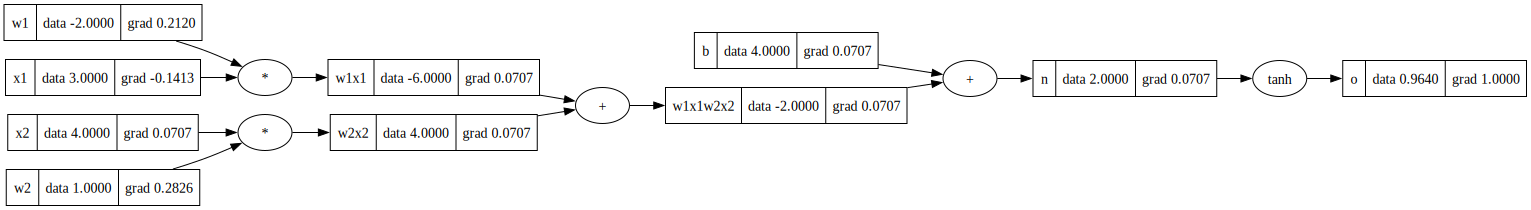

In [5]:
x1 = Value(3.0, label='x1')
x2 = Value(4.0, label='x2')
w1 = Value(-2.0, label='w1')
w2 = Value(1.0, label='w2')

w1x1 = w1*x1
w1x1.label='w1x1'

w2x2 = w2*x2
w2x2.label='w2x2'

w1x1w2x2 = w1x1 + w2x2
w1x1w2x2.label='w1x1w2x2'

b = Value(4.0)
b.label='b'

n = w1x1w2x2 + b
n.label='n'

o = n.tanh()
o.label='o'

o.backward()

draw_dot(o)

In [ ]:
class Neurons:
    """
    This class represents a simple neuron with weights and a forward pass.
    A neuron takes multiple inputs, each associated with a weight, and computes a weighted sum.
    """
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1, 1))
    
    def __call__(self, x, act_fn='tanh'):
        # Forward pass through the neuron: act_fn(weights * inputs + bias)
        act = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias)
        out = act.tanh() if act_fn == 'tanh' else act.relu()
        return act
    
    def parameters(self):
        # return all weights and bias of the neuron
        return self.weights + [self.bias]

class Layer:
    """
    This class represents a layer of neurons in a neural network.
    """
    def __init__(self, nin, nout):
        # create nout neurons, each with nin inputs
        self.neurons = [Neurons(nin) for _ in range(nout)]  

    def __call__(self, x):
        # forward pass through each neuron
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # return all parameters of all neurons in the layer
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP) neural network.
    Its consructor initializes the neural network with a specified number of input and output neurons,
    and a specified number of hidden layers, each with a specified number of neurons.
    """
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        # forward pass through each layer
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
# Example usage of the MLP class
xs = [
    [2.0, 3.0],
    [3.0, -1.0],
    [0.5, 1.0],
    [1.0, 1.0]
]

ys = [11, 11, 3, 5]

n = MLP(2, [4,1])   # A simple MLP with 3 inputs, 2 hidden layers with 4 neurons each, and 1 output neuron
ypred = [n(x) for x in xs]
for i, y in enumerate(ypred):
    print(f"input: {xs[i]}, predicted output: {y.data}, expected output: {ys[i]}")

input: [2.0, 3.0], predicted output: -0.5638438889575266, expected output: 11
input: [3.0, -1.0], predicted output: -0.35896263231230496, expected output: 11
input: [0.5, 1.0], predicted output: -0.28451298646697537, expected output: 3
input: [1.0, 1.0], predicted output: -0.3287355550089605, expected output: 5


In [41]:
for i in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for yout, ygt in zip(ypred, ys))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.00
    loss.backward()

    # step
    for p in n.parameters():
        p.data -= 0.01*p.grad

    print(i, loss.data)

ypred = [n(x) for x in xs]
for i, y in enumerate(ypred):
    print(f"input: {xs[i]}, predicted output: {y.data}, expected output: {ys[i]}")

n.parameters()

0 0.00532806758329245
1 0.005175331309562103
2 0.005156325233770622
3 0.005009547080060569
4 0.00499012721601222
5 0.004849065512474405
6 0.004829294136416504
7 0.00469371738004282
8 0.004673652425429812
9 0.004543338838531034
10 0.0045230341475272955
11 0.004397771255892642
12 0.004377276817438053
13 0.004256861047277337
14 0.004236223222409708
15 0.004120459515226195
16 0.004099721250306295
17 0.003988422694886416
18 0.003967623723354479
19 0.003860611204097217
input: [2.0, 3.0], predicted output: 10.954934081565005, expected output: 11
input: [3.0, -1.0], predicted output: 10.962393194472757, expected output: 11
input: [0.5, 1.0], predicted output: 2.9905108570241845, expected output: 3
input: [1.0, 1.0], predicted output: 4.982549052272859, expected output: 5


[Value(data=-1.6063313909019559),
 Value(data=-0.23527886242847387),
 Value(data=1.4187071656519425),
 Value(data=-0.5318075851835968),
 Value(data=-0.1277003264222678),
 Value(data=0.3026149741483984),
 Value(data=1.6215657851644711),
 Value(data=0.6182794632330647),
 Value(data=-1.432818019345083),
 Value(data=0.6822960086512879),
 Value(data=-0.027841057188798292),
 Value(data=-0.39582615812909977),
 Value(data=-0.9861456693541256),
 Value(data=-0.4021911433216369),
 Value(data=1.1687959417676577),
 Value(data=0.4262546349421872),
 Value(data=3.368473953142427)]

In [43]:
sample = [1.0, 2.0]
ypred = n(sample)
ypred

Value(data=5.976703371670256)